In [5]:
# Script for processing the data from Charlsworth et al. (2015)
# extract the data, read the spikes, filter the data and get bursts and summary statistics
%matplotlib widget
#%% Imports
import os
#os.environ['OPENBLAS_NUM_THREADS'] ='2'
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
import pandas as pd
#import nest
import struct
import json
import sys
import seaborn as sns
from scipy import signal, stats
import subprocess
na = np.array
sys.path.append("..") 
from src.helpers import *
from scipy.io import loadmat as loadmat
import h5py
#%% Helpters for this dataset
import os
from src.data_proc.ephys_utils import gid_to_numbers
from src.data_proc.burst_detection import fixed_bursted_detection

from ipywidgets import interact, widgets
from IPython.display import display

def get_slope(mibi,dur):
    p_up= dur/(mibi+dur)
    mean_x = p_up *9
    return mean_x

In [6]:

def read_ctx_hpc_data(path ='../data/CtxHipp/g2chvcdata-master/inst/extdata/'):
    res = list(os.walk(path,topdown=True))
    files =res[0][2] # all file names 
    spikes  = []
    sources = []
    info = []
    file_names = []
    spike_count_per_channel = []
    gids = []
    for filename in files:
        with h5py.File(path+filename, "r") as f:
            # List all groups
        #     print("Keys: %s" % f.keys())
        #     a_group_key = list(f.keys())[0]

            # Get the data
            age = list(f['meta']['age'])
            if age[0] in [7,10,11,14,17,18,21,24,25,28]:
                # print(age)
                spikes.append(na(f['spikes']))
                sc_ch = list(f['sCount'])
                spike_count_per_channel.append(sc_ch)
                gid = np.repeat(np.arange(len(sc_ch)),sc_ch)
                gids.append(gid)
                names = list(f['names'])
                info.extend(age) # DIV
                reg= list(f['meta']['region'])
                sources.extend(reg)
                file_names.append([filename]*len(reg))
    spikes_data = pd.DataFrame(data={'DIV':info,
                                    'region':sources,
                                    'file':file_names,
                                    'spikes':spikes,
                                    'gids':gids},)#.to_csv('CtxHipp/ctx_hipp_info.csv')
    return spikes_data

data= read_ctx_hpc_data(path ='../../data/CtxHipp/g2chvcdata-master/inst/extdata/')
spikes_data=data

In [7]:
#%%
spks= []
# info = []
# sources =[]
sp_dat = spikes_data['spikes']
gd_dat = spikes_data['gids']
for i in range(len(spikes_data)):
    if len(sp_dat[i])!=len(gd_dat[i]):
        print('i')
    spks.append([sp_dat[i],gd_dat[i]])

In [14]:
np.save('temp_ctx_spike.npy',spks)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (543, 2) + inhomogeneous part.

In [17]:
import pickle
file_path = '../../data/CtxHipp/well_spikes_ctx_hipp'

# Open the file in write-binary mode and use pickle to dump the object
with open(file_path, 'wb') as file:
    pickle.dump(spks, file)


interactive(children=(Text(value='97', description='ind1'), Text(value='170', description='ind2'), FloatSlider…

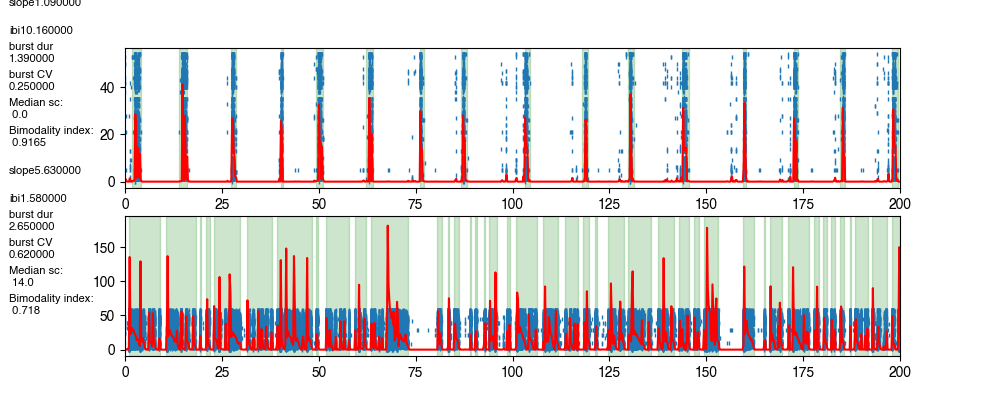

In [5]:
def pop_burst_detection(st,gid,isi_thr,
                            minBdur=50,#100,
                            minIBI=800,#1000,
                            minSburst=200,
                            onset_threshold=3,
                            peak_threshold=5):
    """Detect network burst based on the detection of bursts in
    each electrode and further thresholding

    Args:
        st (list): spike times (is ms )
        gid (list): neuron ids
    Returns:
        pop_bursts_final (list): list of tuples with the start and end of each burst
    """
    st = na(st)
    gid = na(gid)
    gid_ids = np.unique(gid)
    # main vector to store the number of bursts per electrode in each time bin
    burst_vectors = np.ones(shape=(int(np.max(st)),1))
    if False:
        for i,u_id in enumerate(gid_ids):
            st_ =st[gid==u_id]
            # Parameters of the MI from Charlesworth et al. 2016
            bursts = MI_bursts(st_,   
                    maxISIstart=isi_thr,#100,#100.0,
                    maxISIb=250,#250,#isi_thr,#250,
                    minBdur=50,#50,
                    minIBI=800,#500,
                    minSburst=6)
            for burst in bursts:
                # accumulate the number of bursts per electrode in each time bin
                burst_vectors[int(burst[0])-500:int(burst[1])+500,0]+=0
                # plt.plot([int(burst[0])/1000,int(burst[1])/1000],[u_id,u_id],'-',color='r',alpha=0.5)
            
    # add the population detection
    # isi_thr =20
    # isi_thr = 100#min(max(np.median(np.diff(st)),100),500)
    # min(max(np.median(np.diff(st)),1),100)
    bursts = MI_bursts(st,#np.sort(st),   
            maxISIstart=isi_thr,#100.0,
            maxISIb=isi_thr,#isi_thr,
            minBdur=minBdur,#100,
            minIBI=minIBI,#1000,
            minSburst=minSburst)
    
    # print(bursts)
    for burst in bursts:
        burst_vectors[int(burst[0]):int(burst[1]),0]+=10
        # plt.plot([int(burst[0])/1000,int(burst[1])/1000],[0,0],'-',color='g',alpha=1,linewidth=2)
        
        
    # onset_threshold = 3# numer of sim active electrodes to consider a burst
    onset_threshold =1#np.percentile(na(burst_vectors[:,0]),50)#max(np.percentile(na(burst_vectors[:,0]),50),3)#min(np.median(na(burst_vectors[:,0])),3)
    peak_threshold =1#max(np.percentile(na(burst_vectors[:,0]),50),3)#max(np.percentile(na(burst_vectors[:,0]),99),5)
    # plt.plot(np.linspace(int(np.min(st))/1000,int(np.max(st))/1000,len(burst_vectors)),burst_vectors)
    # print(onset_threshold,peak_threshold)
    pop_bursts_final = detect_onests(burst_vectors,
                                     na(burst_vectors[:,0]>onset_threshold,dtype=int),#>onset_threshold
                                     peak_threshold=peak_threshold) 
    return pop_bursts_final
    
@jit(nopython=True)
def detect_onests(burst_vectors, thr_burst_vector,peak_threshold=5):
    """Detect the start and end of the network burst"""
    # detect the start and end of the network burst
    # peak_threshold = 5 # number of max simult active electrodes to consider a peak
    pop_bursts= []
    df_vec = np.diff(thr_burst_vector)
    for i,k in enumerate(df_vec):
        if k>0:
            start = i
        elif k<0:
            end = i
            pop_bursts.append([start,end])
    pop_bursts_final =[]
    for burst in pop_bursts:
        if np.max(burst_vectors[burst[0]:burst[1],0])>=peak_threshold:
            pop_bursts_final.append(burst)
    return pop_bursts_final
from src.helpers import  bimodality_index
def fixed_bursted_detection(st,gid,sc,
                           bi_thr=0.5,
                           isi_thr = 20,
                           minBdur=50,#100,
                           minIBI=800,#1000,
                           minSburst=200
                           ):
    
    bi = bimodality_index(sc)

    if bi>bi_thr:#np.median(sc)<=10:# and 
        # isi_thr =min(max(np.percentile(np.diff(np.sort(st)),75),20),200)
        # isi_thr = np.percentile(np.diff(np.sort(st)),95)
        # plt.figure()
        # plt.hist(np.diff(np.sort(st)),200)
        
        # print(isi_thr)
        # print(isi_thr)
        # isi_thr = 100#min(max(np.mean(np.diff(st)),1),500)
        # isi_thr = min(np.mean(np.diff(st)),100)
        # print(isi_thr)
        bursts = pop_burst_detection(na(st),na(gid),isi_thr,
                                                minBdur=minBdur,#100,
                                                minIBI=minIBI,#1000,
                                                minSburst=minSburst,
                                                 onset_threshold=3,
                                                 peak_threshold=10)
        
        
        bursts= na(bursts)/1000
        # print(bursts.shape)
        # print(np.vstack([np.diff(bursts)<50]))
        if len(bursts)>1:
            max_length = 50#s
            bursts= bursts[np.vstack([np.diff(bursts)<max_length])[:,0],:]
        
    else:
        bursts = []

    return na(bursts)

def dignostic_exclusion(data=None,
                        ax1=None,
                        method=None,
                        bi_thr=0.5,
                         isi_thr = 20,
                         minBdur=50,#100,
                         minIBI=1000,#1000,
                         minSburst=200,
                       ):
        # print('a')
        st = data[0]*1000
        gid = data[1]
        # mean_fr.append(len(st)/np.max(st))
        sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))

        # sc = sc/n_channels
        gid = gid_to_numbers(na(gid))
        n_channels = np.max(gid)
        bursts = na(fixed_bursted_detection(st,gid,sc,
                                     bi_thr=bi_thr,
                                     isi_thr = isi_thr,
                                     minBdur=minBdur,#100,
                                     minIBI=minIBI,#1000,
                                     minSburst=minSburst
                                     ))


        isi = np.diff(np.sort(st));
        bi = bimodality_index(sc)

        col = 'blue' 
        if len(bursts)>2:
            col = 'red'
            # valid[i] = 1
            for burst in bursts:
                ax1.axvspan(burst[0],burst[1],alpha=0.2,color ='g')
            ibis = bursts[1:,0]-bursts[:-1,1]
            durs = np.diff(bursts)
            mibi =np.mean(ibis)
            cvibi = np.std(ibis)/mibi
            mdur = np.mean(durs)
            cvdur = np.std(durs)/mdur
            burst_summary = [mibi,cvibi,mdur,cvdur]
        else:
            burst_summary = [np.nan,np.nan,np.nan,np.nan]   
    
        misi = np.mean(isi)
        ax1.plot(st/1000,gid,'|',markersize=2.5)
        sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))
        slope = get_slope(burst_summary[0],burst_summary[2])
        ax1.plot(times[1:]/1000,sc/n_channels/0.2,color=col)
        ax1.set_xlim(0,200)
        
        values = ['Bimodality index: \n '+str(np.round(bi,4)),
                  'Median sc: \n '+str(np.median(sc)),
                  'burst CV \n'+str('{:f}'.format(np.round(burst_summary[1],2))),
                  'burst dur \n'+str('{:f}'.format(np.round(burst_summary[2],2))),
                  'ibi'+str('{:f}'.format(np.round(burst_summary[0],2))),
                  'slope'+str('{:f}'.format(np.round(slope,2))),
                 ]
        
        for i,string in enumerate(values):
            ax1.text(-0.15, .3+i*0.2, string, fontsize=8, 
                     transform=ax1.transAxes)#plt.gcf().transFigure)
        

fig, ax = plt.subplots(2,1,figsize=(10,4))
@interact( ind1='97', ind2='170',bi_thr=0.5,
             isi_thr_up = (0,1000,20),
             minBdur=(0,500,10),#100,
             minIBI=(0,5000,50),#1000,
             minSburst=(0,1000,5),
             perc=(0,100,.1))
def widget_excl(ind1=1,
                ind2=2,
                bi_thr=0.4,
                isi_thr_up = 100,
                minBdur=50,#100,
                minIBI=1000,#1000,
                minSburst=45,
                perc = 90
               
               ):
    
    
    
    ax[0].clear()
    ax[1].clear()
    # st_s = np.percentile(np.diff(np.sort(spks[int(ind1)][0])*1000),perc)
    # st_s = np.mean(np.diff(np.sort(st)))+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)

    # isi_thr =min(st_s,isi_thr_up)#min(max(st_s,isi_thr),500)
    st = spks[int(ind1)][0]*1000
    st_s = np.mean(np.diff(np.sort(st)))+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)
    # isi_thr =st_s #min(st_s,500)#st_s#min(max(st_s,isi_thr),500)
    isi_thr =min(max(st_s,50),500)#st_s#min(max(st_s,isi_thr),500)
    display(st_s,isi_thr)
    
    # count,_ = np.histogram(np.diff(st),[0,np.mean(np.diff(st))+np.std(np.diff(st))])
    # minSburst=   min(count*(perc/100),200)
    display(minSburst)
    
    dignostic_exclusion(spks[int(ind1)],ax1=ax[0],
                               bi_thr=bi_thr,
                               isi_thr= isi_thr,
                               minBdur=minBdur,
                               minIBI=minIBI,
                               minSburst=minSburst);
    st = spks[int(ind2)][0]*1000
    # st_s = np.percentile(np.diff(np.sort(spks[int(ind2)][0])*1000),perc)
    # isi_thr =min(st_s,isi_thr_up)#st_s#min(max(st_s,isi_thr),500)
    st_s = np.mean(np.diff(np.sort(st)))+np.std(np.diff(np.sort(st))) #np.percentile(np.diff(np.sort(st)),perc)
    isi_thr =min(max(st_s,50),500)#st_s#min(max(st_s,isi_thr),500)
    display(st_s,isi_thr)
    count,_ = np.histogram(np.diff(st),[0,np.mean(np.diff(st))+np.std(np.diff(st))])
    # minSburst=  #min(count*(perc/100),200)
    display(minSburst)
    
    dignostic_exclusion(spks[int(ind2)],ax1=ax[1],
                               bi_thr=bi_thr,
                               isi_thr= isi_thr,
                               minBdur=minBdur,
                               minIBI=minIBI,
                               minSburst=minSburst);

    return None
# (array([234, 235, 236, 237, 238, 239]),)
# [ 96,  97,  98,  99, 100, 101, 114, 115, 116, 117, 118, 119]


# (array([  3,  49,  53,  65,  76, 124, 137, 170, 174, 188, 205, 227, 261,
        # 321, 325, 328, 332, 357, 370, 466, 473, 490]),)


In [6]:
np.where(na(spikes_data['DIV']==28)* na(spikes_data['region']==b'ctx'))

(array([  3,  49,  53,  65,  76, 124, 137, 170, 174, 188, 205, 227, 261,
        321, 325, 328, 332, 357, 370, 466, 473, 490]),)

In [7]:
spikes_data['region']

0      b'ctx'
1      b'hpc'
2      b'hpc'
3      b'ctx'
4      b'hpc'
        ...  
538    b'hpc'
539    b'ctx'
540    b'ctx'
541    b'hpc'
542    b'hpc'
Name: region, Length: 543, dtype: object

In [8]:

def get_summary(data):
    st = na(data[0])*1000
    gid = na(data[1])
    n_units = len(np.unique(gid))
    sc,times = np.histogram(st,np.arange(np.min(st),np.max(st),200.))
    
    st_s = np.mean(np.diff(np.sort(st)))
    isi_thr =min(max(st_s,50),500)
    
    bursts=  fixed_bursted_detection(st,gid,sc,
                           bi_thr=0.4,#0.55,
                           isi_thr = isi_thr,
                           minBdur=50,#100,
                           minIBI=500,#250,#1000,
                           minSburst=45,
                           )
    
    
    # bursts = #method(st,gid,sc)#na(pop_burst_detection(st,gid))/1000#fixed_bursted_de
    # bursts = fixed_bursted_detection(st,sc,
    #                                 min_isi=10,#100.0,
    #                                 max_isi=250,#100.0,
    #                                 minBdur=50,
    #                                 minIBI=500,
    #                                 minSburst=6
    #                                 )
    mean_fr = len(st)/(np.max(st)/1000)
    mean_fr=mean_fr/n_units
    misi = np.mean(np.diff(np.sort(st)))
    if len(bursts)>2:
        ibis = bursts[1:,0]-bursts[:-1,1]
        durs = np.diff(bursts)
        mibi =np.mean(ibis)
        cvibi = np.std(ibis)/mibi
        mdur = np.mean(durs)
        cvdur = np.std(durs)/mdur
        r1 = np.corrcoef(ibis[:],durs[:-1,0])[0,1]
        r2 =np.corrcoef(ibis[:],durs[1:,0])[0,1]
        burst_summary = [mibi,cvibi,mdur,cvdur,r1,r2]
    else:
        burst_summary = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

    return mean_fr,misi,burst_summary

#%%
all_spikes= []
# info = []
# sources =[]
sp_dat = spikes_data['spikes']
gd_dat = spikes_data['gids']
for i in range(len(spikes_data)):
    if len(sp_dat[i])!=len(gd_dat[i]):
        print('i')
    all_spikes.append([sp_dat[i],gd_dat[i]])
    


sum_per_rec = [get_summary(data) for data in all_spikes]
sum_per_rec = na(sum_per_rec,dtype=object)

#%%
spikes_data['mean_fr'] = sum_per_rec[:,0]
spikes_data['misi'] = sum_per_rec[:,1]
spikes_data['burst_summary'] = sum_per_rec[:,2]


In [9]:
#%%
spikes_df = pd.DataFrame(data={'DIV':spikes_data['DIV'],'region':spikes_data['region'],
                    'file':spikes_data['file'],
                    'mean_fr':sum_per_rec[:,0],
                    'misi':sum_per_rec[:,1],
                    'burst_summary':sum_per_rec[:,2],
                    'spikes':all_spikes},)#.to_csv('CtxHipp/ctx_hipp_info.csv')
#%% Visualize summaries 

hipp_data = spikes_df[(spikes_df['region']==b'hpc')]
ctx_data = spikes_df[(spikes_df['region']==b'ctx')]
dat_hipp = pd.DataFrame(data = {'DIV':hipp_data['DIV'], 'cvibi':na(list(hipp_data['burst_summary']))[:,1]})
dat_ctx = pd.DataFrame(data = {'DIV':ctx_data['DIV'], 'cvibi':na(list(ctx_data['burst_summary']))[:,1]})
# sns.boxplot(x='DIV',y='cvibi',data=dat_hipp)
# sns.boxplot(x='DIV',y='cvibi',data=dat_ctx)

#%%
cv1_data = na(list(spikes_df['burst_summary']))[:,1]
cv2_data = na(list(spikes_df['burst_summary']))[:,3]
ibi_data = na(list(spikes_df['burst_summary']))[:,0]
dur_data = na(list(spikes_df['burst_summary']))[:,2]
r1_data = na(list(spikes_df['burst_summary']))[:,4]
r2_data = na(list(spikes_df['burst_summary']))[:,5]
fr_data = na(list(spikes_df['mean_fr']))
dat = pd.DataFrame(data={'DIV':spikes_data['DIV'],
                    'region':spikes_data['region'],
                    # 'mean_fr':sum_per_rec[:,0],
                    'misi':sum_per_rec[:,1],
                    'cvibi':cv1_data,
                    'cvdur':cv2_data,
                    'r1':r1_data,
                    'r2':r2_data,
                    'ibi':ibi_data,
                    'dur':dur_data,
                     'fr':fr_data
                    },)

In [10]:
summ_ch = pd.read_csv('../../data/CtxHipp/ctx_hipp_summary_full2.csv') # Charleseworth
# '../data/CtxHipp/ctx_hipp_summary_full2.csv'
summ_ch['name'] = 'Charleseworth'
summ_ch.rename({'region':'culture_type'},axis=1,inplace=True)
summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'
summ_ch['slope']=get_slope(summ_ch['ibi'],summ_ch['dur'])
dat['slope']=get_slope(dat['ibi'],dat['dur'])

<ipython-input-10-19e1842ebaaf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
<ipython-input-10-19e1842ebaaf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'


<Axes: xlabel='DIV', ylabel='slope'>

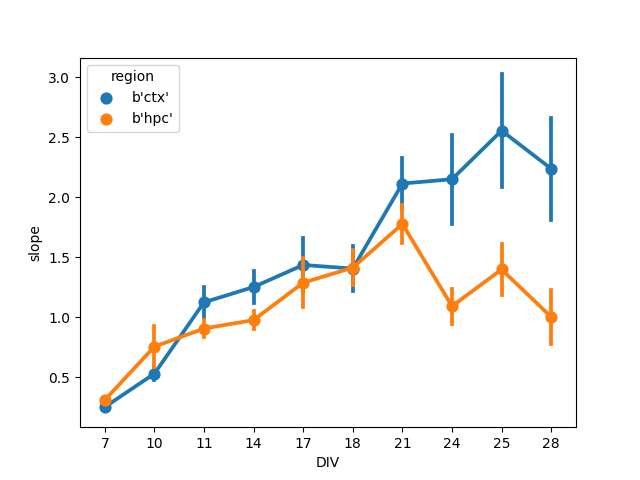

In [11]:
plt.figure()
sns.pointplot(x='DIV',y='slope',hue = 'region',data=dat,errorbar=('se'),)

In [12]:
dat.to_csv('../../data/CtxHipp/ctx_hipp_summary_full_single_v2024.csv') # Charleseworth


In [10]:
# dat=pd.read_csv('../../data/CtxHipp/ctx_hipp_summary_full_single.csv')

<Axes: xlabel='DIV', ylabel='slope'>

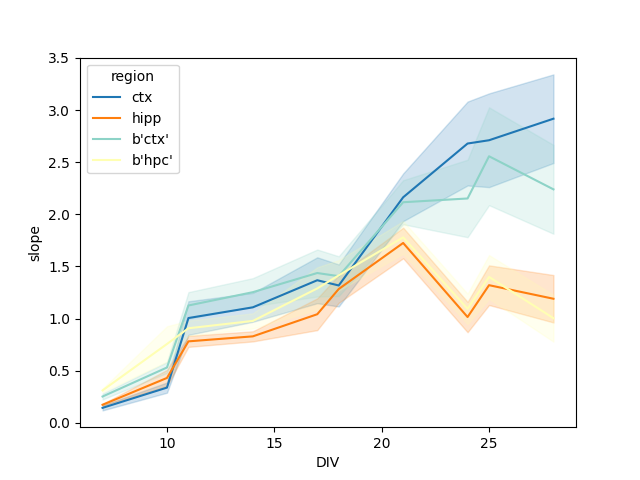

In [11]:
plt.figure()
summ_ch['slope']=get_slope(summ_ch['ibi'],summ_ch['dur'])
sns.lineplot(x='DIV',y='slope',hue = 'culture_type',data=summ_ch, errorbar= 'se')
sns.lineplot(x='DIV',y='slope',hue = 'region',data=dat,errorbar=('se'),palette='Set3')



<Axes: xlabel='DIV', ylabel='slope'>

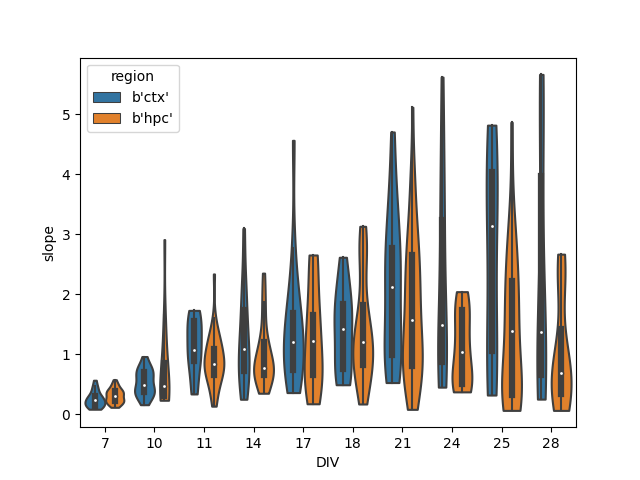

In [13]:
plt.figure()
sns.violinplot(x='DIV',y='slope',hue = 'region',data=dat, cut=0)#errorbar= 'se')

<AxesSubplot:xlabel='DIV', ylabel='fr'>

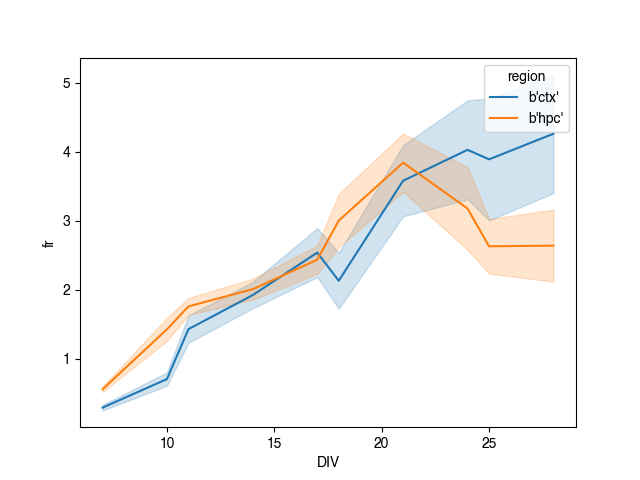

In [228]:
plt.figure()
sns.lineplot(x='DIV',y='fr',hue = 'region',data=dat,errorbar= 'se')

<AxesSubplot:xlabel='DIV', ylabel='cvibi'>

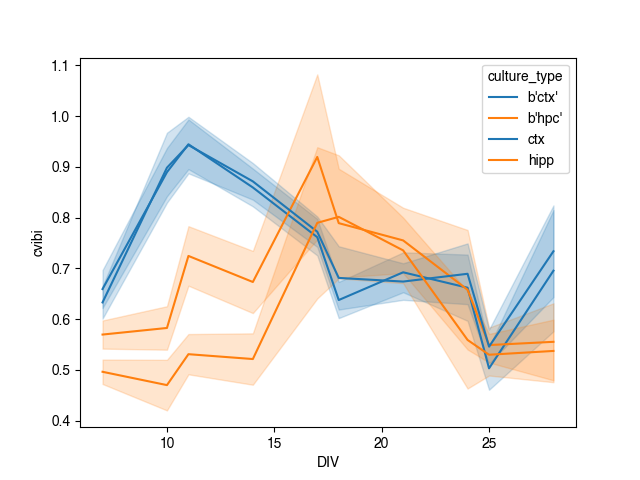

In [206]:
plt.figure()
sns.lineplot(x='DIV',y='cvibi',hue = 'region',data=dat, errorbar= 'se')

sns.lineplot(x='DIV',y='cvibi',hue = 'culture_type',data=summ_ch, errorbar= 'se')


In [8]:
summ_ch = pd.read_csv('../../data/CtxHipp/ctx_hipp_summary_full2.csv') # Charleseworth
# '../data/CtxHipp/ctx_hipp_summary_full2.csv'
summ_ch['name'] = 'Charleseworth'
summ_ch.rename({'region':'culture_type'},axis=1,inplace=True)
summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'

# summ_ch[summ_ch['culture_type']== 'b\'ctx\'] ='ctx'



summ_hy = pd.read_csv('../../data/iPSCcsCTX/summaries_2/ctx_hipp_summary_full_out2.csv') # Hy
# summ_hy = pd.read_csv('../../data/iPSCcsCTX/summaries_2/ctx_hipp_summary_full_out2.csv') # Hy

summ_hy['name'] = 'Hyv'
summ_hy['culture_type'][summ_hy['culture_type']=="Rat"] ='ctx'

summ_hih = pd.read_csv('../../data/summaries/HIH_summary_full.csv') # HIH
summ_hih['name'] = 'HIH'
summ_wag = pd.read_csv('/home/ovinogradov/Projects/ReducedBursting/data/WagenaarData/summariesctx_hipp_summary_full.csv') # HIH
summ_wag['name'] = 'Wagenaar'


# summ_wag_small = pd.read_csv('/home/ovinogradov/Projects/ReducedBursting/data/Wagenaar_small/small_summary_full.csv')
# summ_wag_small['name'] = 'Wagenaar_small'


# toc get kcl samples
summary_frame_kcl = pd.read_pickle('../../data/kcl_summary_full')
summary_WIS = summary_frame_kcl[(summary_frame_kcl['kcl']==4.0)*(summary_frame_kcl['n_bursts']>10.0)]
summary_WIS.rename({'mibi':'ibi','cv':'cvibi','div':'DIV'},axis=1,inplace=True)
summary_WIS['name'] = 'WIS'
summary_WIS['culture_type'] = 'hipp'

all_table = pd.concat([summ_ch, summ_hy,summ_hih,summary_WIS], ignore_index=True, axis=0)
# avg_table = all_table[(all_table['DIV']>14)*(all_table['DIV']<28)].groupby(['name','culture_type']).mean().reset_index()
avg_table = all_table[(all_table['DIV']>14)].groupby(['name','culture_type']).mean().reset_index()


<ipython-input-8-d42fbc904e88>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'ctx'"] ='ctx'
<ipython-input-8-d42fbc904e88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_ch['culture_type'][summ_ch['culture_type']=="b'hpc'"] ='hipp'
<ipython-input-8-d42fbc904e88>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_hy['culture_type'][summ_hy['culture_type']=="Rat"] ='ctx'
<i